In [1]:
# simple_amazon_music_clustering.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

In [ ]:
path = r"C:\Users\user\Desktop\deepika\VS exc\VS Code\unsupervised data\single_genre_artists.csv"
Amazon_Clustering = pd.read_csv(path)
print("Original shape:", Amazon_Clustering.shape)
Amazon_Clustering.info()

Original shape: (95837, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95837 entries, 0 to 95836
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_songs            95837 non-null  object 
 1   name_song           95837 non-null  object 
 2   popularity_songs    95837 non-null  int64  
 3   duration_ms         95837 non-null  int64  
 4   explicit            95837 non-null  int64  
 5   id_artists          95837 non-null  object 
 6   release_date        95837 non-null  object 
 7   danceability        95837 non-null  float64
 8   energy              95837 non-null  float64
 9   key                 95837 non-null  int64  
 10  loudness            95837 non-null  float64
 11  mode                95837 non-null  int64  
 12  speechiness         95837 non-null  float64
 13  acousticness        95837 non-null  float64
 14  instrumentalness    95837 non-null  float64
 15  liveness            95837

In [ ]:
drop_cols = ["id_songs","name_song","popularity_songs","id_artists",
             "time_signature","followers","name_artists","popularity_artists",
             "genres","release_date","explicit","mode"]
# keep only those present
drop_cols = [c for c in drop_cols if c in Amazon_Clustering.columns]
Amazon_Clustering = Amazon_Clustering.drop(columns=drop_cols)
print("After dropping cols:", Amazon_Clustering.shape)

After dropping cols: (95837, 11)


In [ ]:
features = ['danceability','energy','loudness','speechiness','acousticness',
            'instrumentalness','liveness','valence','tempo','duration_ms']

# ensure features exist
features = [f for f in features if f in Amazon_Clustering.columns]
print("Using features:", features)

Amazon_Clustering = Amazon_Clustering.dropna(subset=features).reset_index(drop=True)
print("After dropna shape:", Amazon_Clustering.shape)

Using features: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
After dropna shape: (95837, 11)


In [ ]:
Amazon_Clustering['duration_seconds'] = Amazon_Clustering['duration_ms'] / 1000
Amazon_Clustering['energy_per_sec'] = Amazon_Clustering['energy'] / Amazon_Clustering['duration_seconds'].replace(0, 1)
Amazon_Clustering['dance_energy_ratio'] = Amazon_Clustering['danceability'] / Amazon_Clustering['energy'].replace(0, 0.001)

# Add these new features to feature list
extra = ['energy_per_sec','dance_energy_ratio']
features = features + [f for f in extra if f in Amazon_Clustering.columns]

In [ ]:
scaler = MinMaxScaler()
X = Amazon_Clustering[features].values
X_scaled = scaler.fit_transform(X)

In [11]:
# Step 1: Create an empty dictionary to store silhouette scores
sil_scores = {}

# Step 2: Try different numbers of clusters (k = 2 to 8)
for k in range(2, 9):  # 9 is excluded, so 2–8
    print("Running KMeans for k =", k)
    
    # Step 3: Create the KMeans model for current k
    kmeans = KMeans(
        n_clusters=k,        # number of groups
        random_state=42,     # same result each time
        n_init=10            # run 10 times to pick the best
    )
    
    # Step 4: Fit the model on scaled data and get labels (group numbers)
    labels = kmeans.fit_predict(X_scaled)
    
    # Step 5: Calculate silhouette score for this k
    score = silhouette_score(X_scaled, labels)
    
    # Step 6: Store this score in dictionary
    sil_scores[k] = score
    
    # Step 7: Print result for this k
    print(score)

# Step 8: Find which k had the highest silhouette score
best_k = max(sil_scores, key=sil_scores.get)
best_score = sil_scores[best_k]

# Step 9: Print the best result
print("Best number of clusters (k):", best_k)
print("Best Silhouette Score:", round(best_score, 4))




Running KMeans for k = 2
0.26252756912776654
Running KMeans for k = 3
0.3201779472667252
Running KMeans for k = 4
0.3179715667467755
Running KMeans for k = 5
0.2627414219096709
Running KMeans for k = 6
0.24208913732194287
Running KMeans for k = 7
0.25324440834000583
Running KMeans for k = 8
0.25599522122688445
Best number of clusters (k): 3
Best Silhouette Score: 0.3202

Best number of clusters (k): 3
Best Silhouette Score: 0.3202


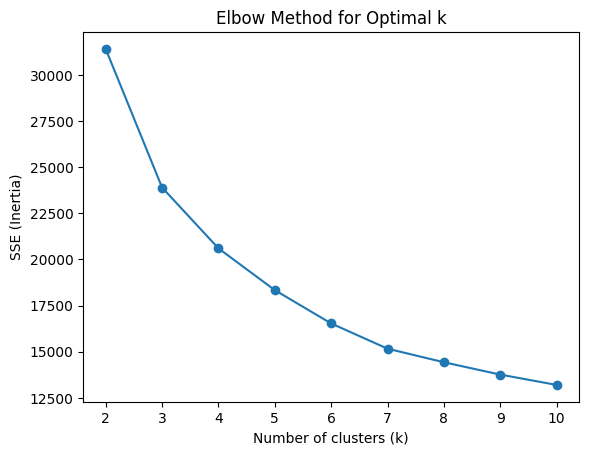

In [9]:
# 9) Elbow method (SSE) for KMeans
sse = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(list(k_values), sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.xticks(list(k_values))
plt.show()



In [12]:
# ------------------------------
# Make sure your main dataset exists
# Example: if your original dataset is named "Amazon_Clustering"
# and has the same rows as X_scaled

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_scaled)

# ✅ Add cluster labels to your original dataframe
# (Ensure Amazon_Clustering is defined before this)
Amazon_Clustering["Cluster"] = clusters

# Check result
print(Amazon_Clustering.head())

NameError: name 'Amazon_Clustering' is not defined

In [ ]:
cluster_profile = Amazon_Clustering.groupby('Cluster')[features].mean().round(3)
print(cluster_profile)

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for c in sorted(Amazon_Clustering['Cluster'].unique()):
    mask = Amazon_Clustering['Cluster']==c
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f'Cluster {c}', alpha=0.6)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('KMeans clusters (PCA 2D)')
plt.legend()
plt.show()

In [ ]:
db = DBSCAN(eps=0.5, min_samples=5)
db_labels = db.fit_predict(X_scaled)
n_db_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print("DBSCAN clusters (excluding noise):", n_db_clusters)
# if >=2 clusters compute silhouette for non-noise
if n_db_clusters >= 2:
    mask = db_labels != -1
    print("DBSCAN silhouette (non-noise):", silhouette_score(X_scaled[mask], db_labels[mask]))

In [ ]:
Amazon_Clustering.to_csv("amazon_music_with_clusters.csv", index=False)
print("Saved: amazon_music_with_clusters.csv")